<a href="https://colab.research.google.com/github/matteomrz/20242R0136COSE47402/blob/main/final/final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Final Project

### Imports and Preparation

In [1]:
# Hide Output with %%capture
%%capture
!pip install openai-clip
!pip install datasets
!pip install torch
!pip install tqdm

In [2]:
import clip
import torch
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image
from torch.utils.data import Dataset
import torch.nn as nn
from datasets import load_dataset
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.optim as optim
from torch import nn

## Image Classification

### Prepare Dataset

In [3]:
ds = load_dataset("bazyl/GTSRB")

train = ds['train']
test = ds['test']

base_label = 'a picture of a '
end_label = ' street sign'

id_to_description = {
    18: "General Caution",
    19: "Dangerous curve left",
    20: "Dangerous curve right",
    21: "Winding road",
    22: "Bumpy road",
    23: "Slippery road",
    24: "Road narrows on the right",
    25: "Road work",
    26: "Traffic lights",
    27: "Pedestrians",
    28: "Children crossing",
    29: "Bike crossing",
    30: "Beware of ice/snow",
    31: "Wild animals crossing"
}

train = [example for example in train if example['ClassId'] in id_to_description]
test = [example for example in test if example['ClassId'] in id_to_description]

for instance in train:
    instance['Description'] = base_label + id_to_description[instance['ClassId']] + end_label

# All classes tokenized array for Prediction
all_classes = torch.cat([clip.tokenize(base_label + description + end_label) for description in id_to_description.values()])

len_train = int(0.8 * len(train))
train, val = random_split(train, [len_train, len(train) - len_train])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/4.83k [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/3.46k [00:00<?, ?B/s]

(…)-00000-of-00001-dc762c064c221993.parquet:   0%|          | 0.00/236M [00:00<?, ?B/s]

(…)-00000-of-00001-747a54d4a6461a97.parquet:   0%|          | 0.00/76.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/39209 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/12630 [00:00<?, ? examples/s]

In [4]:
class WarningSignDataset(Dataset):
  def __init__(self, data, is_test = False):
    self.data = data
    self.is_test = is_test

  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    item = self.data[idx]
    image = Image.open(BytesIO(item['Path']['bytes']))
    text = item['Description'] if not self.is_test else ''
    class_id = item['ClassId'] - min(id_to_description.keys())
    return preprocess(image), text, class_id

In [5]:
# Data Loaders for Train, Val and Test
train_dataloader = DataLoader(WarningSignDataset(train),batch_size = 32, shuffle=True)
val_dataloader = DataLoader(WarningSignDataset(val),batch_size = 32, shuffle=False)
test_dataloader = DataLoader(WarningSignDataset(test, is_test=True),batch_size = 32, shuffle=False)

### Initialize CLIP Model

In [6]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32",device=device,jit=False)

100%|███████████████████████████████████████| 338M/338M [00:03<00:00, 96.5MiB/s]


#### Baseline: Zero-Shot

In [7]:
# Baseline Quantitative Results: CLIP Zero-Shot Prediction
model.eval()
total = 0
correct = 0
with torch.no_grad():
  for images, _, classId in test_dataloader:
    images= images.to(device)
    texts = all_classes.to(device)
    logits_per_image, logits_per_text = model(images, texts)
    pred = torch.argmax(logits_per_image, dim=-1).cpu().numpy()
    total += len(images)
    correct += (classId == pred).sum().item()

print(f"Zero Shot Accuracy: {100*correct/total}%")

Zero Shot Accuracy: 21.68776371308017%


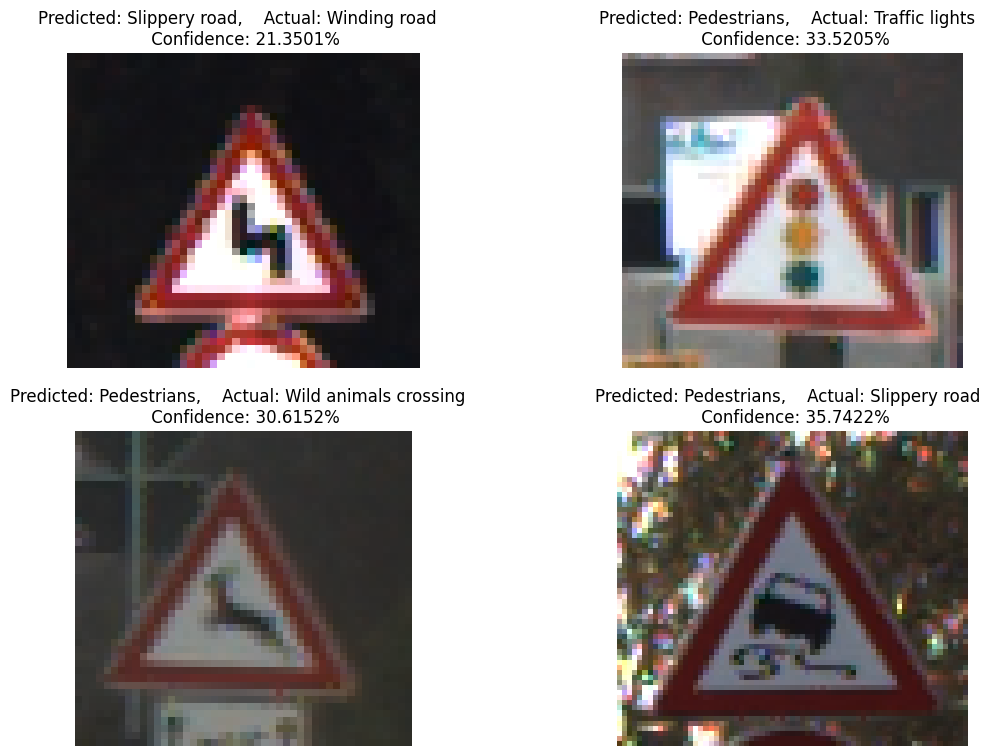

In [8]:
# Baseline Qualitative Results: CLIP Zero-Shot Prediction
idx = [20, 37, 102, 387]

fig, axes = plt.subplots(2, 2, figsize=(13, 9))

model.eval()
for i, index in enumerate(idx):
  data_entry = test[index]
  image = Image.open(BytesIO(data_entry['Path']['bytes']))
  image_input = preprocess(image).unsqueeze(0).to(device)
  texts = all_classes.to(device)

  with torch.no_grad():
    logits_per_image, logits_per_text = model(image_input, texts)

  prob = logits_per_image.softmax(dim=-1)[0].cpu().numpy()
  pred = logits_per_image.argmax(dim=-1)[0].cpu().numpy()

  axes[int(i/2)][i%2].imshow(image)
  axes[int(i/2)][i%2].set_title(f"Predicted: {id_to_description[int(pred) + min(id_to_description.keys())]}, \
   Actual: {id_to_description[int(data_entry['ClassId'])]}  \n Confidence: {100 * prob[pred]:.4f}%")
  axes[int(i/2)][i%2].axis('off')

### Fine-tune CLIP model on GTSRB dataset

In [9]:
from tqdm import tqdm

# code for training pipeline and clip initialization from
# https://github.com/openai/CLIP/issues/83#issue-853114174

# without this the loss is NaN
# https://github.com/openai/CLIP/issues/57
def convert_models_to_fp32(model):
  for p in model.parameters():
    p.data = p.data.float()
    p.grad.data = p.grad.data.float()

loss_img = nn.CrossEntropyLoss()
loss_txt = nn.CrossEntropyLoss()

# Try out different optimizers
optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-5)
# SGD showed no promising results
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, weight_decay=8e-5)

# Model reaches 99%+ accuracy after one iteration,
# so big epoch_num not required
# One epoch enough?
epoch_num = 1

for epoch in range(epoch_num):

  # TRAINING
  model.train()
  running_loss = 0.0
  pbar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epoch_num}, Loss: 0.0000")
  for images, texts, _ in pbar :
    optimizer.zero_grad()

    images= images.to(device)
    texts = clip.tokenize(texts).to(device)

    logits_per_image, logits_per_text = model(images, texts)

    ground_truth = torch.arange(len(images),dtype=torch.long,device=device)

    total_loss = (loss_img(logits_per_image,ground_truth) + loss_txt(logits_per_text,ground_truth))/2
    total_loss.backward()
    running_loss += total_loss.item()

    # Fixes NaN loss
    if device == "cpu":
      optimizer.step()
    else :
      convert_models_to_fp32(model)
      optimizer.step()
      clip.model.convert_weights(model)

    pbar.set_description(f"Epoch {epoch+1}/{epoch_num}, Loss: {running_loss/len(train_dataloader):.4f}")

  print(f"Epoch {epoch+1}/{epoch_num}, Loss: {running_loss/len(train_dataloader):.4f}")

  # VALIDATION
  model.eval()
  total = 0
  correct = 0
  with torch.no_grad():
    for images, texts, classId in val_dataloader:
      images= images.to(device)
      texts = clip.tokenize(texts).to(device)
      image_features = model.encode_image(images)
      text_features = model.encode_text(texts)
      logits_per_image, logits_per_text = model(images, texts)
      pred = torch.argmax(logits_per_image, dim=-1).cpu().numpy()
      total += len(images)

      # prediction uses first text in the batch that fits the image the most,
      # so check if classid of the predicted text is right
      for i in range(len(images)):
        if classId[i] == classId[pred[i]]:
          correct += 1

  print(f"Validation Accuracy: {100*correct/total}%")

# save model
torch.save(model.state_dict(), 'clip_finetuned.pth')

Epoch 1/1, Loss: 1.3932: 100%|██████████| 192/192 [00:43<00:00,  4.38it/s]


Epoch 1/1, Loss: 1.3932
Validation Accuracy: 99.15032679738562%


### Testing the fine-tuned Model

In [10]:
# TESTING
# Quantitative Results: Prediction after fine-tuning the base CLIP model
model.eval()
total = 0
correct = 0
with torch.no_grad():
  for images, _, classId in test_dataloader:
    images= images.to(device)
    texts = all_classes.to(device)
    logits_per_image, logits_per_text = model(images, texts)
    pred = torch.argmax(logits_per_image, dim=-1).cpu().numpy()
    total += len(images)
    correct += (classId == pred).sum().item()

print(f"Test Accuracy: {100*correct/total}%")

Test Accuracy: 95.82278481012658%


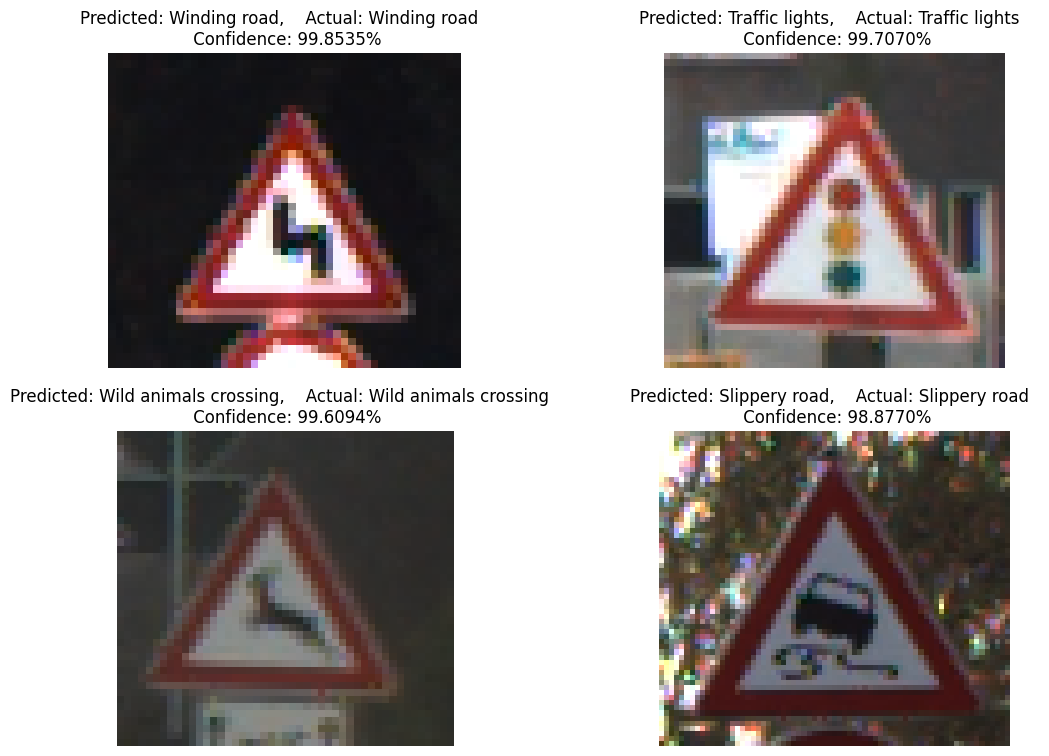

In [11]:
# Qualitative Results: Prediction after fine-tuning the base CLIP model
idx = [20, 37, 102, 387]

fig, axes = plt.subplots(2, 2, figsize=(13, 9))

model.eval()
for i, index in enumerate(idx):
  data_entry = test[index]
  image = Image.open(BytesIO(data_entry['Path']['bytes']))
  image_input = preprocess(image).unsqueeze(0).to(device)
  texts = all_classes.to(device)

  with torch.no_grad():
    logits_per_image, logits_per_text = model(image_input, texts)

  prob = logits_per_image.softmax(dim=-1)[0].cpu().numpy()
  pred = logits_per_image.argmax(dim=-1)[0].cpu().numpy()

  axes[int(i/2)][i%2].imshow(image)
  axes[int(i/2)][i%2].set_title(f"Predicted: {id_to_description[int(pred) + min(id_to_description.keys())]}, \
   Actual: {id_to_description[int(data_entry['ClassId'])]}  \n Confidence: {100 * prob[pred]:.4f}%")
  axes[int(i/2)][i%2].axis('off')

## Object Detection

In [12]:
%%capture
# Code for object detection from
# https://github.com/deepmancer/clip-object-detection/blob/b78ba8bf08a07d46d51c1d3c2e2e36264582fbad/clip_object_detection.ipynb
# with changes to fit to specific use case

import torchvision
from torchvision import transforms
from torchvision.utils import draw_bounding_boxes
import requests

# faster_rcnn computes the candidate bounding boxes and
# fine-tuned CLIP model performs classification
faster_rcnn = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(
    weights="DEFAULT",
)
faster_rcnn.roi_heads.score_thresh = 0.3

faster_rcnn.eval()

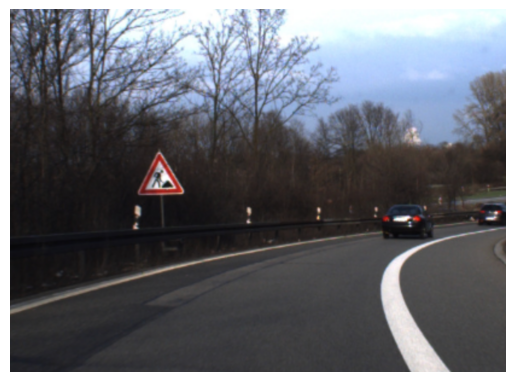

In [19]:
scene_link = 'construction_scene.png'
image = Image.open(scene_link)
plt.imshow(image)
plt.axis("off")
plt.show()

In [20]:
image_t = transforms.ToTensor()(image.convert('HSV'))
candidates = faster_rcnn(image_t.unsqueeze(0))[0]

In [21]:
def plot_image_with_boxes(image, boxes, labels=None, figsize=(8,6)):
    fig, ax = plt.subplots(1, figsize=figsize)

    ax.imshow(image)

    for i, box in enumerate(boxes):
        x_min, y_min, x_max, y_max = box
        rect = plt.Rectangle(
            (x_min, y_min),
            x_max - x_min,
            y_max - y_min,
            linewidth=1,
            edgecolor="green",
            facecolor="none",
        )
        ax.add_patch(rect)

        if labels is not None:
            label_size = len(labels[i]) * 10
            ax.text(
                x_min + (x_max - x_min) / 2 - label_size / 2,
                y_min - 10,
                labels[i],
                fontsize=12,
                verticalalignment="top",
                color="white",
                bbox=dict(facecolor="green", alpha=0.5, edgecolor="none"),
            )

    plt.tight_layout(pad=0)
    plt.axis('off')
    plt.show()

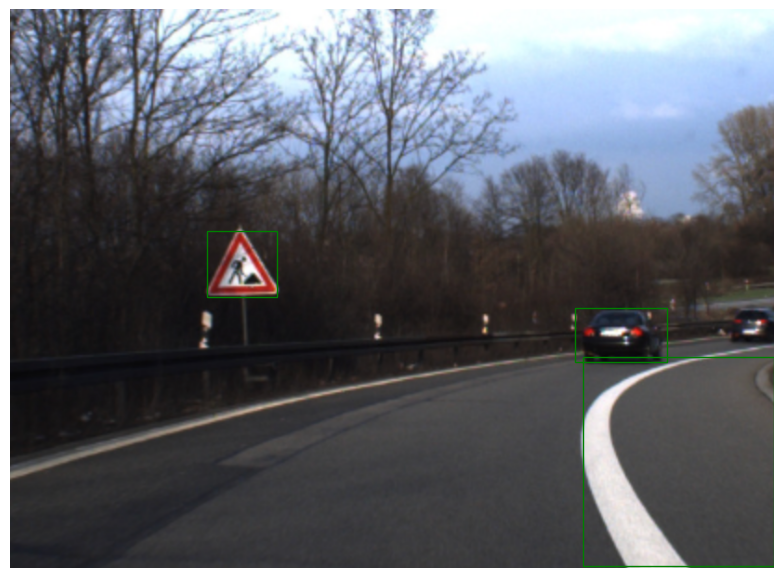

In [22]:
boxes = candidates['boxes'].detach()
plot_image_with_boxes(image=image, boxes=boxes)

In [23]:
import numpy as np

height, width = image_t.shape[-2:]

labels = []
sign_boxes = []
model.eval()

scene_classes = all_classes.to(device)

for box in boxes:
  #check dimensions of box
  x_min, y_min, x_max, y_max = map(int, box)
  x_max, y_max = min(width, x_max), min(height, y_max)

  if x_min > x_max or x_min > width or y_min > y_max or y_min > height:
      continue

  cropped_image = image_t[:, y_min:y_max+1, x_min:x_max+1]
  if not torch.prod(torch.tensor(cropped_image.shape)):
      continue

  cropped_image = preprocess(transforms.functional.to_pil_image(cropped_image)).unsqueeze(0).to(device)

  with torch.no_grad():
    logits_per_image, logits_per_text = model(cropped_image, scene_classes)

  prob = logits_per_image.softmax(dim=-1)[0].cpu().numpy()
  pred = logits_per_image.argmax(dim=-1)[0].cpu().numpy()

  # model has high test accuracy, so expecting a high confidence to avoid false positives
  if prob[pred] > 0.6:
      labels.append(f'{id_to_description[int(pred) + min(id_to_description.keys())]} ({100 * prob[pred]:.2f}%)')
      sign_boxes.append(box)

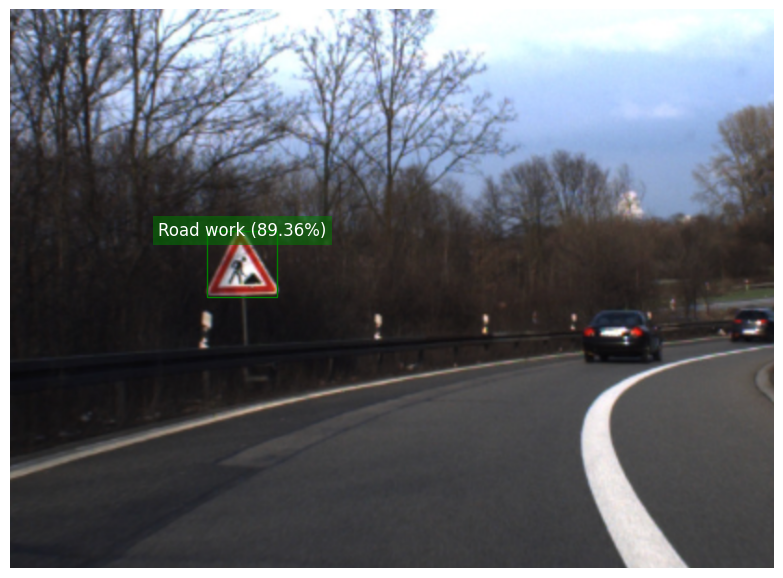

In [24]:
plot_image_with_boxes(image=image, boxes=sign_boxes, labels=labels)